# CUDA C Best Practices Guide -- Shared Memory Optimisations

Change the following to run the same analysis on a different problem size:

In [9]:
%env OCLGRIND=/oclgrind
%env PROBLEM_SIZE=tiny
# %env PROBLEM_SIZE=small
# %env PROBLEM_SIZE=medium
# %env PROBLEM_SIZE=large

# set-up compulsory stuff
%load_ext rpy2.ipython

env: OCLGRIND=/oclgrind
env: PROBLEM_SIZE=tiny
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Generate runtime data

In [10]:
! make clean
! make

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11


Run the experiment and collect runtime data

In [11]:
! cat ./gpu-strided-global-memory-access-unoptimised.cl

//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)


__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    const int globalRow = get_global_id(0); // Row ID of C (0..M)
    const int globalCol = get_global_id(1); // Col ID of C (0..N)
 
    // Compute a single element (loop over K)
    float acc = 0.0f;
    for (int k=0; k<N; k++) {
        acc += b[k*N + globalCol] * a[globalRow*N + k];
    }
 
    // Store the result
    c[globalRow*N + globalCol] = acc;
}

__kernel void coalescedMultiply(const __global float* A, 
                                const __global float* B,
                                __global float* C, const int N)
{
    __local float aTile[TILE_DIM][TILE_DIM];

    const int localRow = get_local_id(0);
    const int localCol = get_local_id(1);

    const int globalRow = get_gl

In [12]:
! ./gpu-stride ./gpu-strided-global-memory-access-unoptimised.cl $PROBLEM_SIZE 0 1 runtime

***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)


__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    const int globalRow = get_global_id(0); // Row ID of C (0..M)
    const int globalCol = get_global_id(1); // Col ID of C (0..N)
 
    // Compute a single element (loop over K)
    float acc = 0.0f;
    for (int k=0; k<N; k++) {
        acc += b[k*N + globalCol] * a[globalRow*N + k];
    }
 
    // Store the result
    c[globalRow*N + globalCol] = acc;
}

__kernel void coalescedMultiply(const __global float* A, 
                                const __global float* B,
                                __global float* C, const int N)
{


M = 64 N = 64 total KiB = 48
Operating on a 64x64 matrix with a tile size 32...
******* LSB_Finalize *******


## Analyse runtimes data -- to ensure the OpenCL port of the cuda codes matches those shown in CUDA code-book

In [13]:
import pandas as pd
x = pd.read_csv('lsb.gpu_memory_access.r0', comment='#', sep="\s+")
#print(x)

y = x[(x.region == 'simpleMultiply_kernel') | (x.region == 'coalescedMultiply_kernel') | (x.region == 'sharedABMultiply_kernel')]



The distributions of 100 runtimes for each of the 3 kernels of memory striding for GPU optimisations are shown below.

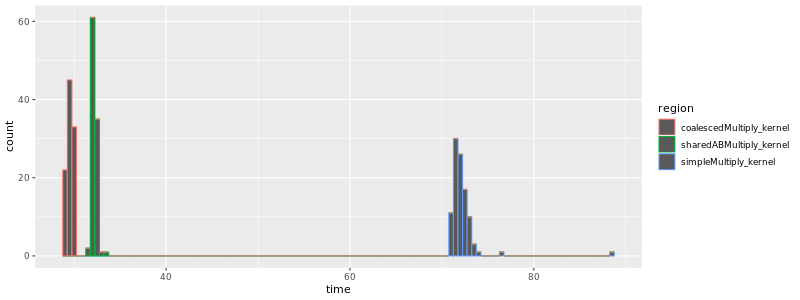

In [14]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.5)
print(pp)

**NOTE:** Do these distributions appear suspect? Perhaps move the timing regions to outside of the loop and divide by iterations -- in the C host source

In [15]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (ms)'})
z.groupby(["region"]).median()

,time (ms)
region,
coalescedMultiply_kernel,29.467773
sharedABMultiply_kernel,32.207031
simpleMultiply_kernel,71.862305


## Generate AIWC feature-space per kernel

In [16]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./gpu-stride ./gpu-strided-global-memory-access-unoptimised.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)


__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    const int globalRow = get_global_id(0); // Row ID of C (0..M)
    const i

Architecture-Independent Workload Characterization of kernel: simpleMultiply
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: icmp count: 266240
instruction: phi count: 532480
instruction: sext count: 528384
instruction: ret count: 4096
instruction: store count: 4096
instruction: add count: 790528
instruction: br count: 532480
instruction: call count: 270336
instruction: getelementptr count: 528384
instruction: load count: 524288
instruction: trunc count: 8192
instruction: mul count: 266240
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+============================================================================+
Unique Op Codes comprising of 90% of dynamic instructions:
	add
	p

1		8.66545
2		8.66546
3		8.66546
4		8.66543
5		8.66545
6		8.66547
7		8.16451
8		7.18318
9		6.22025
10		5.24889
+-------------------------------------------------------------------------------------------------------+
|Unique Branch Instructions -- Total number of unique branch instructions to cover 90% of the branches|
+=======================================================================================================+
Branch At Line	Count (hit and miss)
40		270336
35		12288
Number of unique branches that cover 90% of all branch instructions: 1
+-------------------------------------------------------------------------------------------------------+
|Branch Entropy -- Measure of the randomness of branch behaviour, representing branch predicability     |
+=======================================================================================================+
Using a branch history of 16
Yokota Branch Entropy: 32804.3
Yokota Branch Entropy Per Workload: 15.455
Average Linear Branch En

Operand sum: 3.48979e+06
Mean data width: 1
stdev data width: 0
Granularity: 2.8655e-07
Barriers Per Instruction : 0.00586883
Instructions Per Operand : 1
+--------------------------------------------------------------------------+
|Total Memory Footprint -- total number of unique memory addresses accessed|
+==========================================================================+
20480
+----------------------------------------------------------------------------------------------+
|90% Memory Footprint -- Number of unique memory addresses that cover 90% of memory accesses   |
+==============================================================================================+
total number of memory accesses = 561152
90% of memory accesses:505037
Number of unique memory addresses that cover 90% of memory accesses: 7653
+----------------------------------------------------------------------------------------------+
|Global Memory Address Entropy -- Measure of the randomness of memory addre

## Analyse AIWC data

First load in new data

In [17]:
import pandas as pd
simpleMultiply = pd.read_csv('aiwc_simpleMultiply_0.csv', sep=",")
coalescedMultiply = pd.read_csv('aiwc_coalescedMultiply_0.csv', sep=",")
sharedABMultiply = pd.read_csv('aiwc_sharedABMultiply_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [18]:
%%R -i simpleMultiply -i coalescedMultiply -i sharedABMultiply -o featdata.all

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

simpleMultiply$application <- "matrix_multiplication"
simpleMultiply$kernel <- "simple_multiply"
simpleMultiply$invocation <- 0
simpleMultiply$size <- Sys.getenv('PROBLEM_SIZE')

coalescedMultiply$application <- "matrix_multiplication"
coalescedMultiply$kernel <- "coalesced_multiply"
coalescedMultiply$invocation <- 0
coalescedMultiply$size <- Sys.getenv('PROBLEM_SIZE')

sharedABMultiply$application <- "matrix_multiplication"
sharedABMultiply$kernel <- "shared_ab_multiply"
sharedABMultiply$invocation <- 0
sharedABMultiply$size <- Sys.getenv('PROBLEM_SIZE')

featdata.all <- rbind(featdata.all,simpleMultiply)
featdata.all <- rbind(featdata.all,coalescedMultiply)
featdata.all <- rbind(featdata.all,sharedABMultiply)

Studentise the AIWC data

In [19]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)
pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$granularity <- scale(pca_dat$granularity,scale=TRUE)[,1]
pca_dat$barriers_per_instruction <- scale(pca_dat$barriers_per_instruction,scale=TRUE)[,1]
pca_dat$instructions_per_operand <- scale(pca_dat$instructions_per_operand,scale=TRUE)[,1]
pca_dat$total_instruction_count <- scale(pca_dat$total_instruction_count,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$operand_sum <- scale(pca_dat$operand_sum,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]
aiwc <- pca_dat

Comparison between AIWC feature-spaces

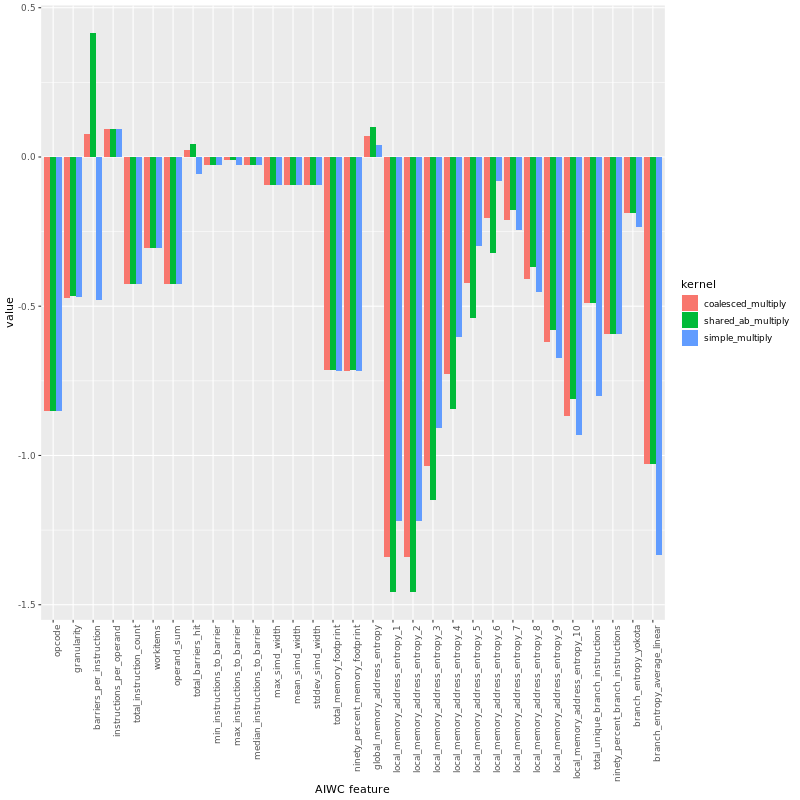

In [21]:
%%R -i aiwc -w 800 -h 800 -u px

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "matrix_multiplication")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))


## Prediction Accuracy Of AIWC Metrics

Generate the predictive model

In [34]:
%%R -o model

library(ranger)

load("/opencl-predictions-with-aiwc/data/intermediate/full_dat.Rda")

#manually typecast integer variables
int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
num.inds <- lapply(full_dat, is.numeric)
num.inds <- as.logical(num.inds)

for (i in seq(along = num.inds)){
            feature.name = names(full_dat[i])
            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, full_dat[i] <- scale(full_dat[i]))
                                } #end i loop

#use 20% of data for training
#sampled_indices <- sample(seq_len(nrow(full_dat)), size = round(nrow(full_dat)*0.2))
#train_dat <- full_dat[sampled_indices, ]
#test_dat <- full_dat[-sampled_indices, ]
#or...
#use 100% of data for training
train_dat <- full_dat

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -size)
train_dat = subset(train_dat, select = -application)
train_dat = subset(train_dat, select = -kernel)
train_dat = subset(train_dat, select = -total_time)

#build the model
rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = train_dat,
                   num.trees = 505,
                   mtry = 30,
                   min.node.size = 9,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

model <- rgd.aiwc

Make prediction with our AIWC metrics

In [35]:
%%R -i aiwc -i model -o predicted

#manually typecast integer variables
#int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
#num.inds <- lapply(aiwc, is.numeric)
#num.inds <- as.logical(num.inds)

#for (i in seq(along = num.inds)){
#            feature.name = names(aiwc[i])
#            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, aiwc[i] <- scale(aiwc[i]))
#                                } #end i loop
predicted <- data.frame()

x <- subset(aiwc, kernel=="simple_multiply")
x$device = 'gtx1080'
x$run = 0
prediction <- predict(model,type='response',data=x)
print(paste("simple multiply", round(exp(prediction$pred),digits=2), "(ms)"))
predicted <- rbind(predicted, data.frame('region'='simple_multiply','predicted time (ms)'=round(exp(prediction$pred),digits=2)))

x <- subset(aiwc, kernel=="coalesced_multiply")
x$device = 'gtx1080'
x$run = 0
prediction <- predict(model,type='response',data=x)
print(paste("coalesced multiply", round(exp(prediction$pred),digits=2), "(ms)"))
predicted <- rbind(predicted, data.frame('region'='coalesced_multiply','predicted time (ms)'=round(exp(prediction$pred),digits=2)))

x <- subset(aiwc, kernel=="shared_ab_multiply")
x$device = 'gtx1080'
x$run = 0
prediction <- predict(model,type='response',data=x)
print(paste("shared ab multiply", round(exp(prediction$pred),digits=2), "(ms)"))
predicted <- rbind(predicted, data.frame('region'='shared_ab_multiply','predicted time (ms)'=round(exp(prediction$pred),digits=2)))


[1] "simple multiply 102.6 (ms)"
[1] "coalesced multiply 99.79 (ms)"
[1] "shared ab multiply 97.03 (ms)"


Compare predictions against measured times

In [ ]:
groundtruth = z
groundtruth = groundtruth.groupby(['region']).mean()

groundtruth = groundtruth.rename({'simpleMultiply_kernel':'simple_multiply',
                                  'coalescedMultiply_kernel':'coalesced_multiply',
                                  'sharedABMultiply_kernel':'shared_ab_multiply'})
comparison = pd.merge(predicted,groundtruth,left_on='region',right_on='region')
comparison.head()

**Note:** The predictive accuracy is bad for both the simple and coalesced case -- reasons?

# Loop Blocking Example 4-25 from Intel 64 and IA-32 Architectures Optimization Reference Manual

## Generate runtime data

Run the experiment and collect runtime data

In [ ]:
! make clean; make
! ./cpu-loop-block ./cpu-loop-blocking.cl $PROBLEM_SIZE 1 0 runtime

## Analyse runtime data

In [38]:
import pandas as pd
x = pd.read_csv('lsb.cpu_loop_blocking.r0', comment='#', sep="\s+")

y = x[(x.region == 'original_loop_kernel') | (x.region == 'transformed_loop_after_blocking_kernel')]



The distributions of 100 runtimes for each of the 2 kernels is shown below.

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


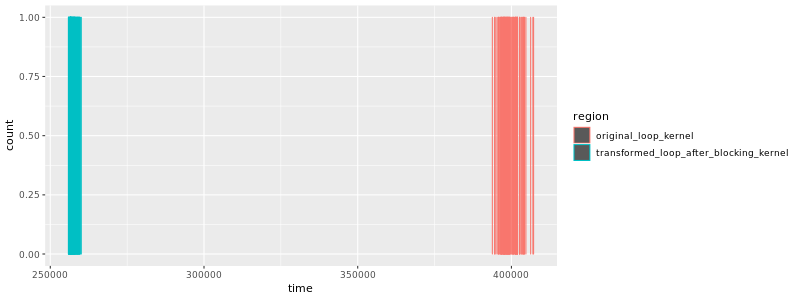

In [39]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.1)
print(pp)

In [105]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (mins)'})
z.groupby(["region"]).median()*1.66667e-5

## Generate AIWC feature-space per kernel

In [44]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./cpu-loop-block ./cpu-loop-blocking.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11 -g -O0
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >cpu_loop_blocking< writing to >lsb.cpu_loop_blocking.r0< *****
Attempting kernel: ./cpu-loop-blocking.cl with contents:
//Loop Blocking Example 4-25 from https://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-optimization-manual.pdf in Section 4.5.3 Loop Blocking

__kernel void original_loop(__global float* A, __global float* B)
{
    //get_group_id(0) * get_local_size(0) + get_local_id(0);//not needed -- intel tests only for single thread
    for (int i=0; i< MAX; i++) {
        for (int j=0; j< MAX; j++) {
            //A[i,j] = A[i,j] + B[j, i];
            A[i*MAX+j] = A[i*MAX+j] + B[j*MAX+i];
        } 
    }
}

__kernel void tr

total number of memory accesses = 50331648
90% of memory accesses:45298484
Number of unique memory addresses that cover 90% of memory accesses: 6964
+----------------------------------------------------------------------------------------------+
|Global Memory Address Entropy -- Measure of the randomness of memory addresses                |
+==============================================================================================+
12.9176
+----------------------------------------------------------------------------------------------+
|Local Memory Address Entropy -- Measure of the spatial locality of memory addresses           |
+==============================================================================================+
LSBs skipped	Entropy (bits)
1		12.9185
2		12.9185
3		11.9184
4		10.9182
5		9.9196
6		8.92039
7		7.92111
8		6.9286
9		5.93409
10		4.95851
+-------------------------------------------------------------------------------------------------------+
|Unique Branch Ins

## Analyse AIWC data

First load in new data

In [45]:
import pandas as pd
originalLoop = pd.read_csv('./aiwc_original_loop_0.csv', sep=",")
transformedLoop = pd.read_csv('aiwc_transformed_loop_after_blocking_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [46]:
%%R -i originalLoop -i transformedLoop -o featdata.all

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

originalLoop$application <- "loop_blocking"
originalLoop$kernel <- "original_loop"
originalLoop$invocation <- 0
originalLoop$size <- "tiny"

transformedLoop$application <- "loop_blocking"
transformedLoop$kernel <- "transformed_loop"
transformedLoop$invocation <- 0
transformedLoop$size <- "tiny"

featdata.all <- rbind(featdata.all,originalLoop)
featdata.all <- rbind(featdata.all,transformedLoop)


/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Studentise the AIWC data

In [47]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)
pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$granularity <- scale(pca_dat$granularity,scale=TRUE)[,1]
pca_dat$barriers_per_instruction <- scale(pca_dat$barriers_per_instruction,scale=TRUE)[,1]
pca_dat$instructions_per_operand <- scale(pca_dat$instructions_per_operand,scale=TRUE)[,1]
pca_dat$total_instruction_count <- scale(pca_dat$total_instruction_count,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$operand_sum <- scale(pca_dat$operand_sum,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]
aiwc <- pca_dat

Comparison between AIWC feature-spaces

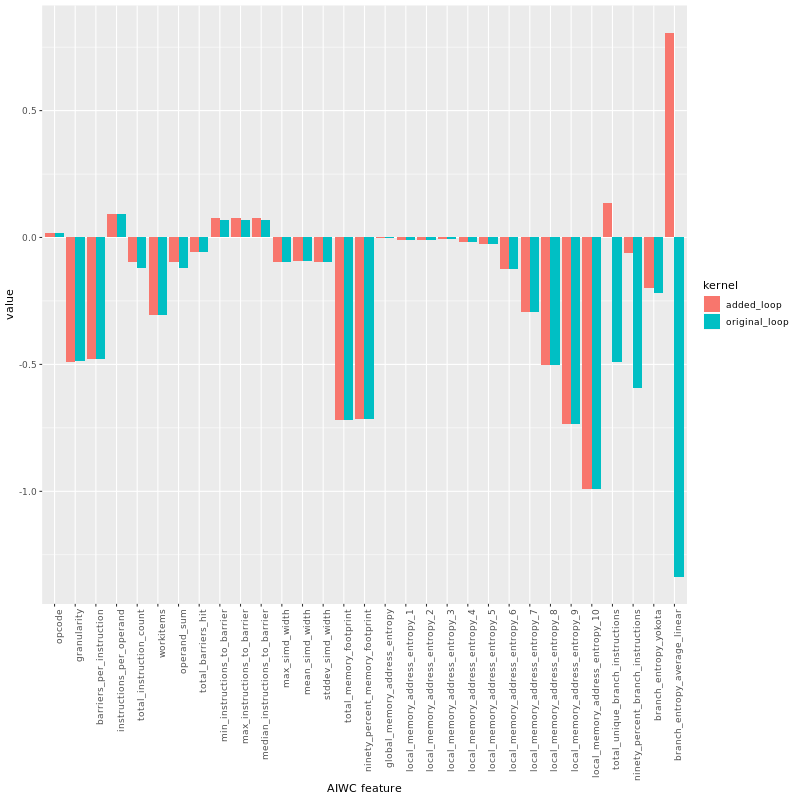

In [48]:
%%R -i aiwc -w 800 -h 800 -u px

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "loop_blocking")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))


# Vectorization of Mandelbrot Set -- Example 5-33 from Intel 64 and IA-32 Architectures Optimization Reference Manual

This example examines the ability to improve the performance of CPU devices by using vectorisation / Single Instruction Multiple Data (SIMD) level optimization. This is done by first examining the code to produce a Mandelbrot set -- a sample is shown in Figure 1.

<img src="mandelbrot.png" width="200" alt="Figure 1. Mandelbrot set">

<!--
![Figure 1. Mandelbrot set](mandelbrot.png =250x)
-->

The optimization involves restucturing the code to pack four floating point values into the same register allowing 128 bits to be treated in the same instruction. The Intel codebook, from which this example was based, originally targeted SSEv4. However, since this is intel specific an OpenCL alternative was developed. Support for vectorization comes built into OpenCL using vector primatives. 

## Generate runtime data

Run the experiment and collect runtime data

In [100]:
! make clean; make
! ./cpu-mandelbrot-vectorization ./cpu-mandelbrot-vectorization-set-map.cl $PROBLEM_SIZE 1 0 runtime

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >cpu_vectorization< writing to >lsb.cpu_vectorization.r0< *****
Attempting kernel: ./cpu-mandelbrot-vectorization-set-map.cl with contents:
//Example 5-32 Baseline C Code for Mandelbrot Set Map Evaluation from:https://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-optimization-manual.pdf

//#define DIMX (64)
//#define DIMY (64)
//#define X_STEP (0.5f/DIMX)
//#define Y_STEP (0.4f/(DIMY/2))
__kernel void mandelbrot(__global int* map)
{
    int i,j;
    float x = -1.8f;
    for (i=

## Analyse runtime data

In [101]:
import pandas as pd
x = pd.read_csv('lsb.cpu_vectorization.r0', comment='#', sep="\s+")

y = x[(x.region == 'mandelbrot_kernel') | (x.region == 'mandelbrot_vectorized_kernel')]



The distributions of 100 runtimes for each of the 2 kernels is shown below.

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


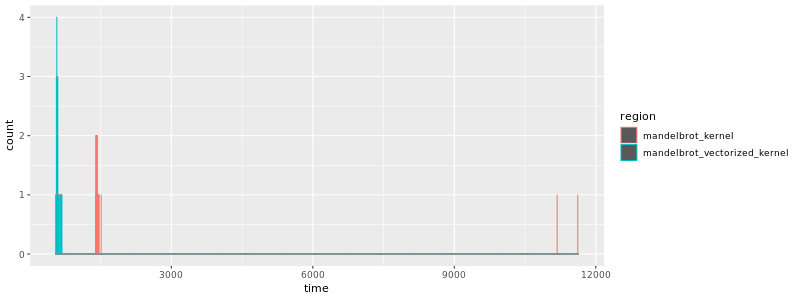

In [102]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.1)
print(pp)

In [104]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (ms)'})
z.groupby(["region"]).median()

## Generate AIWC feature-space per kernel

In [112]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./cpu-mandelbrot-vectorization ./cpu-mandelbrot-vectorization-set-map.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >cpu_vectorization< writing to >lsb.cpu_vectorization.r0< *****
Attempting kernel: ./cpu-mandelbrot-vectorization-set-map.cl with contents:
//Example 5-32 Baseline C Code for Mandelbrot Set Map Evaluation from:https://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-optimization-manual.pdf

//#define DIMX (64)
//#define DIMY (64)
//#define X_STEP (0.5f/DIMX)
//#define Y_STEP (0.4f/(DIMY/2))
__kernel void mandelbrot(__global int* map)
{
    int i,j;
    float x = -1.8f;
    for (i=

Using a branch history of 16
Yokota Branch Entropy: 395339
Yokota Branch Entropy Per Workload: 78.5417
Average Linear Branch Entropy: 0.0491087
The Architecture-Independent Workload Characterisation was written to file: aiwc_mandelbrot_0.csv
Mandelbrot:
Architecture-Independent Workload Characterization of kernel: mandelbrot_vectorized
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: fmul count: 2129088
instruction: fadd count: 36864
instruction: add count: 2135680
instruction: call count: 9330112
instruction: sext count: 1086272
instruction: br count: 5424896
instruction: getelementptr count: 36864
instruction: phi count: 7558976
instruction: fsub count: 1049408
instruction: shl count: 4096
instruction: icmp count: 4301696
instruction: ret count: 64
+-------------------------------------

## Analyse AIWC data

First load in new data

In [113]:
import pandas as pd
mandelbrot = pd.read_csv('./aiwc_mandelbrot_0.csv', sep=",")
mandelbrotVectorized = pd.read_csv('./aiwc_mandelbrot_vectorized_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [114]:
%%R -i mandelbrot -i mandelbrotVectorized -o featdata.all

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

mandelbrot$application <- "mandelbrot_set"
mandelbrot$kernel <- "mandelbrot"
mandelbrot$invocation <- 0
mandelbrot$size <- Sys.getenv('PROBLEM_SIZE')

mandelbrotVectorized$application <- "mandelbrot_set"
mandelbrotVectorized$kernel <- "mandelbrot_vectorized"
mandelbrotVectorized$invocation <- 0
mandelbrotVectorized$size <- Sys.getenv('PROBLEM_SIZE')

featdata.all <- rbind(featdata.all,mandelbrot)
featdata.all <- rbind(featdata.all,mandelbrotVectorized)


/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Studentise the AIWC data

In [115]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)
pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$granularity <- scale(pca_dat$granularity,scale=TRUE)[,1]
pca_dat$barriers_per_instruction <- scale(pca_dat$barriers_per_instruction,scale=TRUE)[,1]
pca_dat$instructions_per_operand <- scale(pca_dat$instructions_per_operand,scale=TRUE)[,1]
pca_dat$total_instruction_count <- scale(pca_dat$total_instruction_count,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$operand_sum <- scale(pca_dat$operand_sum,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]
aiwc <- pca_dat

Comparison between AIWC feature-spaces

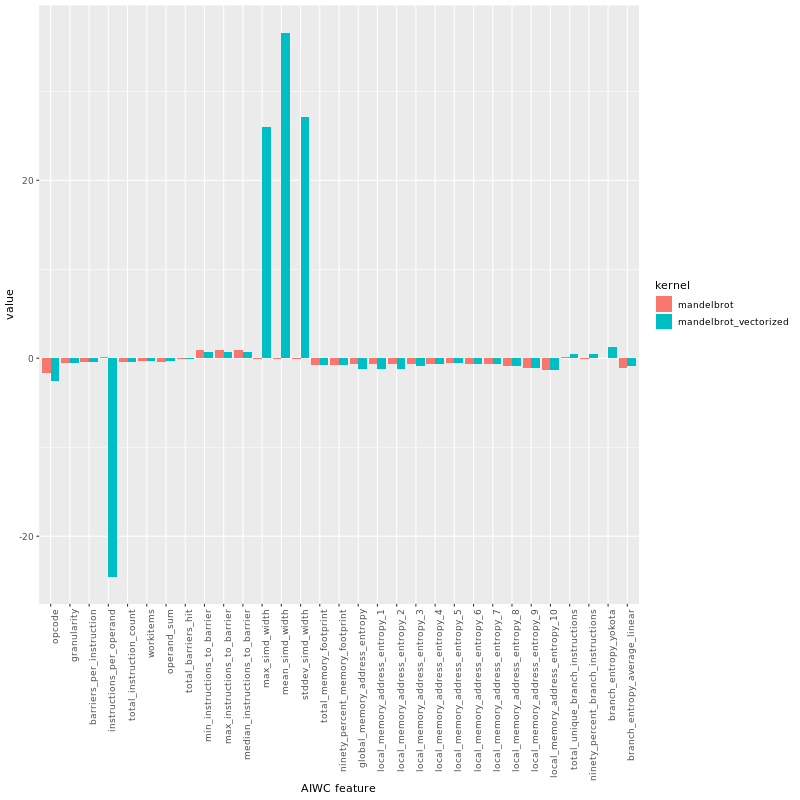

In [116]:
%%R -i aiwc -w 800 -h 800 -u px

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "mandelbrot_set")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
